# Sequential Conv + Pool +Flatten + Dense

## 00. Imports

In [1]:
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from sklearn.metrics import confusion_matrix

In [2]:
import sys
sys.path.append("../")

In [3]:
from src.activation.relu import ReluLayer
from src.layers.pooling import MaxPoolLayer
from src.activation.softmax import SoftmaxLayer
from src.layers.dense import DenseLayer
from src.layers.flatten import FlattenLayer
from src.layers.convolutional import ConvLayer2D
from src.model.sequential import SequentialModel
from src.utils.core import convert_categorical2one_hot, convert_prob2categorical
from src.utils.metrics import calculate_accuracy
from src.optimizers.gradient_descent import GradientDescent
from src.optimizers.rms_prop import RMSProp
from src.optimizers.adam import Adam

## 01. Settings

In [4]:
# number of samples in the train data set
N_TRAIN_SAMPLES = 30000
# number of samples in the test data set
N_TEST_SAMPLES = 1000
# number of samples in the validation data set
N_VALID_SAMPLES = 1000
# number of classes
N_CLASSES = 10
# image size
IMAGE_SIZE = 28

## 02. Build data set

In [5]:
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
print("trainX shape:", trainX.shape)
print("trainY shape:", trainY.shape)
print("testX shape:", testX.shape)
print("testY shape:", testY.shape)

trainX shape: (60000, 28, 28)
trainY shape: (60000,)
testX shape: (10000, 28, 28)
testY shape: (10000,)


In [6]:
X_train = trainX[:N_TRAIN_SAMPLES, :, :]
y_train = trainY[:N_TRAIN_SAMPLES]

X_test = trainX[N_TRAIN_SAMPLES:N_TRAIN_SAMPLES+N_TEST_SAMPLES, :, :]
y_test = trainY[N_TRAIN_SAMPLES:N_TRAIN_SAMPLES+N_TEST_SAMPLES]

X_valid = testX[:N_VALID_SAMPLES, :, :]
y_valid = testY[:N_VALID_SAMPLES]

**NOTE:** We need to change the data format to the shape supported by my implementation.

In [7]:
X_train = X_train / 255
X_train = np.expand_dims(X_train, axis=3)
y_train = convert_categorical2one_hot(y_train)
X_test = X_test / 255
X_test = np.expand_dims(X_test, axis=3)
y_test = convert_categorical2one_hot(y_test)
X_valid = X_valid / 255
X_valid = np.expand_dims(X_valid, axis=3)
y_valid = convert_categorical2one_hot(y_valid)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)

X_train shape: (30000, 28, 28, 1)
y_train shape: (30000, 10)
X_test shape: (1000, 28, 28, 1)
y_test shape: (1000, 10)
X_valid shape: (1000, 28, 28, 1)
y_valid shape: (1000, 10)


## 03. Build model

In [8]:
layers = [
    # input (N, 28, 28, 1) out (N, 26, 26, 16)
    ConvLayer2D.initialize(filters=16, kernel_shape=(3, 3, 1), stride=1),
    # input (N, 26, 26, 16) out (N, 26, 26, 16)
    ReluLayer(),
    # input (N, 26, 26, 16) out (N, 13, 13, 16)
    MaxPoolLayer(pool_size=(2, 2), stride=2),
    # input (N, 13, 13, 16) out (N, 9, 9, 32)
    ConvLayer2D.initialize(filters=32, kernel_shape=(5, 5, 16), stride=1),
    # input (N, 9, 9, 32) out (N, 9, 9, 32)
    ReluLayer(),
     # input (N, 9, 9, 32) out (N, 3, 3, 32)
    MaxPoolLayer(pool_size=(3, 3), stride=3),
    # input (N, 3, 3, 32) out (N, 288)
    FlattenLayer(),
    DenseLayer.initialize(units_prev=288, units_curr=256),
    ReluLayer(),
    DenseLayer.initialize(units_prev=256, units_curr=256),
    ReluLayer(),
    DenseLayer.initialize(units_prev=256, units_curr=128),
    ReluLayer(),
    DenseLayer.initialize(units_prev=128, units_curr=64),
    ReluLayer(),
    DenseLayer.initialize(units_prev=64, units_curr=N_CLASSES),
    SoftmaxLayer()
]

optimizer = Adam(lr=0.003)

model = SequentialModel(
    layers=layers,
    optimizer=optimizer
)

## 04. Train

In [9]:
model.train(
    x_train=X_train, 
    y_train=y_train, 
    x_test=X_test, 
    y_test=y_test, 
    epochs=30,
    batch_size=128,
    test_frequency=1
)

Iteration: 00001 - cost: 0.56466 - accuracy: 0.78200
Iteration: 00002 - cost: 0.48750 - accuracy: 0.81700
Iteration: 00003 - cost: 0.46811 - accuracy: 0.81500
Iteration: 00004 - cost: 0.42104 - accuracy: 0.83300
Iteration: 00005 - cost: 0.39308 - accuracy: 0.84700
Iteration: 00006 - cost: 0.38205 - accuracy: 0.85000
Iteration: 00007 - cost: 0.38302 - accuracy: 0.84900
Iteration: 00008 - cost: 0.37326 - accuracy: 0.85100
Iteration: 00009 - cost: 0.36052 - accuracy: 0.85100
Iteration: 00010 - cost: 0.36142 - accuracy: 0.85700
Iteration: 00011 - cost: 0.36548 - accuracy: 0.86100
Iteration: 00012 - cost: 0.37315 - accuracy: 0.84600
Iteration: 00013 - cost: 0.35988 - accuracy: 0.85600
Iteration: 00014 - cost: 0.35718 - accuracy: 0.86600
Iteration: 00015 - cost: 0.35365 - accuracy: 0.86300
Iteration: 00016 - cost: 0.35876 - accuracy: 0.86400
Iteration: 00017 - cost: 0.35742 - accuracy: 0.86800
Iteration: 00018 - cost: 0.36417 - accuracy: 0.87000
Iteration: 00019 - cost: 0.36589 - accuracy: 0

## 05. Predict and examine results

In [10]:
y_hat = model.predict(X_valid)
acc = calculate_accuracy(y_hat, y_valid)
print("acc: ", acc)

acc:  0.853


In [11]:
y_hat = convert_prob2categorical(y_hat)
y_valid = convert_prob2categorical(y_valid)

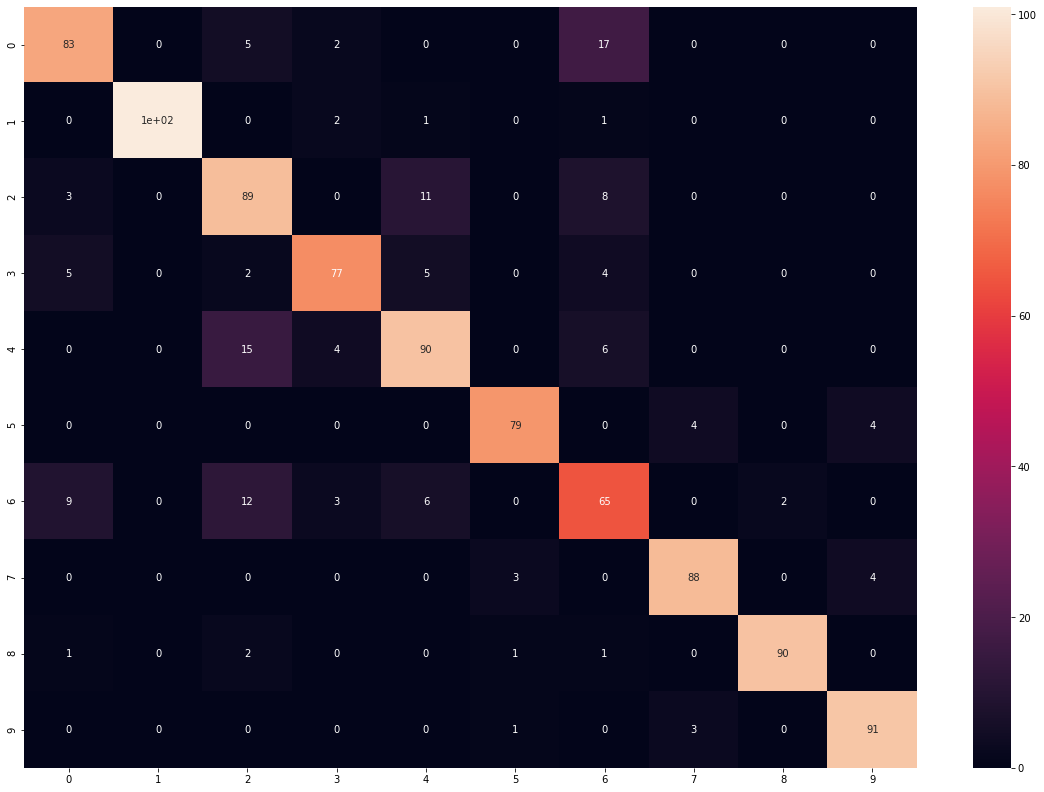

In [12]:
df_cm = pd.DataFrame(
    confusion_matrix(y_valid, y_hat), 
    range(10), 
    range(10)
)
plt.figure(figsize = (20,14))
sn.heatmap(df_cm, annot=True)
plt.show()